In [7]:
import json
import os.path
import pickle

import librosa
import numpy as np
import pandas as pd
from bidict import bidict
from keras.src.callbacks import ModelCheckpoint
from keras.src.utils import to_categorical
from matplotlib import pyplot as plt
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from models.instrument_first_models import CNN_One, RNN_One
from utils.config import IRMAS_MFCC_Config

from utils.instrument_data import InstrumentDataManipulator, DataPreprocessor, IRMASDataManipulator
from scipy.io import wavfile

from sklearn.utils import compute_class_weight
from keras.models import load_model

#### Load General Config

In [8]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["IRMAS_Training_Path_Alt"]

CLASS_DICTIONARY = bidict({
    0 : "cel",
    1 : "cla",
    2 : "flu",
    3 : "gac",
    4 : "gel",
    5 : "org",
    6 : "pia",
    7 : "sax",
    8 : "tru",
    9 : "vio",
    10 : "voi"
})

#### Load DataFrame information and Class Distribution

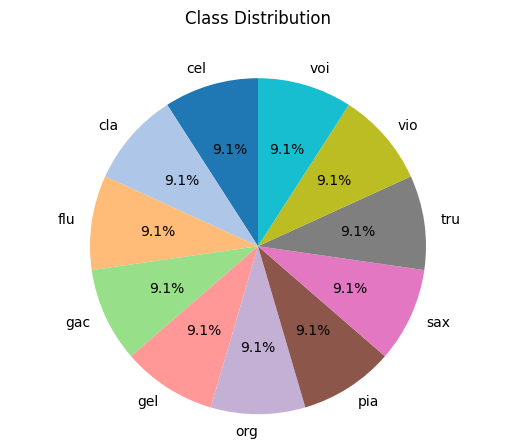

Index(['cel\008__[cel][nod][cla]0058__1.wav',
       'cel\008__[cel][nod][cla]0058__2.wav',
       'cel\008__[cel][nod][cla]0058__3.wav',
       'cel\012__[cel][nod][cla]0043__1.wav',
       'cel\012__[cel][nod][cla]0043__2.wav',
       'cel\012__[cel][nod][cla]0043__3.wav',
       'cel\013__[cel][nod][cla]0025__1.wav',
       'cel\013__[cel][nod][cla]0025__2.wav',
       'cel\013__[cel][nod][cla]0025__3.wav',
       'cel\014__[cel][nod][cla]0041__1.wav',
       ...
       'voi\[voi][pop_roc]2545__3.wav', 'voi\[voi][pop_roc]2546__1.wav',
       'voi\[voi][pop_roc]2546__2.wav', 'voi\[voi][pop_roc]2546__3.wav',
       'voi\[voi][pop_roc]2547__1.wav', 'voi\[voi][pop_roc]2547__2.wav',
       'voi\[voi][pop_roc]2547__3.wav', 'voi\[voi][pop_roc]2548__1.wav',
       'voi\[voi][pop_roc]2548__2.wav', 'voi\[voi][pop_roc]2548__3.wav'],
      dtype='object', name='filename', length=6705)


In [9]:
df = pd.read_csv('../statistics/irmas.csv')
df.set_index('filename', inplace=True)

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)

colors = plt.cm.tab20(np.arange(len(class_dist)) / len(class_dist))

ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

n_samples = 2 * int(df['length'].sum()/0.1) # a tenth of a second

prob_dist = class_dist / class_dist.sum() # probability distribution of each instrument being picked

print(df.index)

#### Fitting and saving the models

In [12]:
config = IRMAS_MFCC_Config(model_path="../instrument_models/pre_split/IRMASconv.keras", pickle_path="../instrument_pickles/pre_split/IRMASconv")
data_manipulator = IRMASDataManipulator(config)

model_wrapper = None
y_flat = None
X, y = None, None

X, y = data_manipulator.build_data_for_CNN(dataset_path = dataset_path, df=df, classes=classes)
print("X shape : ", X.shape)
print("y shape : ", y.shape) # one-hot encoded class matrix

y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
print("CNN Input Shape : ", input_shape)

model_wrapper = CNN_One(input_shape=input_shape, output_shape=len(classes))
model_wrapper.create_model()

Loading existing data for CNN_One model
X shape :  (6705, 298, 13, 1)
y shape :  (6705, 11)
CNN Input Shape :  (298, 13, 1)


C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 298, 13, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 298, 13, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 298, 13, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 298, 13, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 149, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 114432)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,647,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,753,547 (56.28 MB)

 Trainable params: 14,753,547 (56.28 MB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

In [13]:
checkpoint = ModelCheckpoint(filepath=config.model_path, monitor='val_acc', verbose=1, mode="max", save_best_only=True, save_weights_only=False)

model_wrapper.model.fit(X, y, epochs=10, batch_size=32, shuffle=True, validation_split=0.1, callbacks=[checkpoint])

model_wrapper.model.save(config.model_path)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - acc: 0.1354 - loss: 2.3348 - mse: 0.0816
Epoch 1: val_acc improved from -inf to 0.00000, saving model to instrument_models/IRMASconv.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 65s 337ms/step - acc: 0.1357 - loss: 2.3343 - mse: 0.0816 - val_acc: 0.0000e+00 - val_loss: 4.1541 - val_mse: 0.1030
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - acc: 0.3636 - loss: 1.8538 - mse: 0.0699
Epoch 2: val_acc did not improve from 0.00000
189/189 ━━━━━━━━━━━━━━━━━━━━ 63s 332ms/step - acc: 0.3638 - loss: 1.8534 - mse: 0.0699 - val_acc: 0.0000e+00 - val_loss: 3.6008 - val_mse: 0.1048
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - acc: 0.4732 - loss: 1.5902 - mse: 0.0617
Epoch 3: val_acc improved from 0.00000 to 0.03130, saving model to instrument_models/IRMASconv.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 65s 345ms/step - acc: 0.4732 - loss: 1.5900 - mse: 0.0617 - val_acc: 0.0313 - val_loss: 3.7254 - val_mse: 0.1084
Epoch 4/10
189/189 ━━━━━━━━━━━